In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.modules import conv
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

# 配置参数
BATCH_SIZE = 16        # 根据显存情况调整
IMG_SIZE = 224         # 输入图像尺寸
NUM_EPOCHS = 50        # 训练轮数
LR = 3e-4              # 初始学习率
NUM_WORKERS = 0        # 数据加载线程数
device = torch.device('cuda')

class MedicineDataset(Dataset):
	def __init__(self, paths, labels, transform=None):
		self.paths = [os.path.join('chinese-medicine-image', p.replace('/', os.sep)) for p in paths]
		self.labels = labels
		self.transform = transform

	def __len__(self):
		return len(self.paths)

	def __getitem__(self, idx):
		try:
			image = Image.open(self.paths[idx]).convert('RGB')
			if self.transform:
				image = self.transform(image)
			return image, self.labels[idx]
		except Exception as e:
			print(f"\nError loading {self.paths[idx]}: {str(e)}")
			return None

def custom_collate(batch):
	batch = list(filter(lambda x: x is not None, batch))
	return torch.utils.data.dataloader.default_collate(batch)

if __name__ == '__main__':
	# 数据准备
	df = pd.read_csv('chinese-medicine-image/train_labels.csv', header=0)
	df = df.rename(columns={'ID': 'path', 'Label': 'label'})
	convert_dict = {'path': str, 'label': int}
	df = df.astype(convert_dict)
	paths = df['path'].values
	# 转换为0-based索引
	# 注意：如果标签从1开始，则需要减去1
	labels = df['label'].values - 1


	# 划分数据集
	train_paths, val_paths, train_labels, val_labels = train_test_split(
		paths, labels, test_size=0.2, stratify=labels, random_state=42
	)

	# 数据增强
	train_transform = transforms.Compose([
		transforms.RandomResizedCrop(IMG_SIZE), # 随机裁剪
		transforms.RandomHorizontalFlip(), # 随机水平翻转
		transforms.RandomRotation(15), # 随机旋转
		transforms.ColorJitter(0.1, 0.1, 0.1), # 随机颜色抖动
		transforms.ToTensor(), # 转换为Tensor
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 归一化处理
	])

	val_transform = transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(IMG_SIZE),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
	])

	# 创建数据集和数据加载器
	train_dataset = MedicineDataset(train_paths, train_labels, train_transform)
	val_dataset = MedicineDataset(val_paths, val_labels, val_transform)

	train_loader = DataLoader(
		train_dataset,
		batch_size=BATCH_SIZE,
		shuffle=True,
		num_workers=NUM_WORKERS,
		pin_memory=True,
		collate_fn=custom_collate
	)
	val_loader = DataLoader(
		val_dataset,
		batch_size=BATCH_SIZE,
		shuffle=False,
		num_workers=NUM_WORKERS,
		pin_memory=True,
		collate_fn=custom_collate
	)

	# 模型配置
	model = models.efficientnet_b3(pretrained=True)
	num_features = model.classifier[1].in_features
	model.classifier[1] = nn.Linear(num_features, 881)
	model = model.to(device)

	# 训练配置
	optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
	scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS) # 学习率调度
	criterion = nn.CrossEntropyLoss()
	scaler = torch.cuda.amp.GradScaler()

	# 训练循环
	best_acc = 0.0
	for epoch in range(NUM_EPOCHS):
		model.train()
		train_loss = 0.0
		correct = 0
		total = 0

		loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}]', mininterval=1)
		for images, targets in loop:
			# 跳过空batch
			if images is None or targets is None:
				continue

			images = images.to(device, non_blocking=True)
			targets = targets.to(device, non_blocking=True).long()  # 关键修改
			
			optimizer.zero_grad()
			
			with torch.cuda.amp.autocast():
				outputs = model(images)
				loss = criterion(outputs, targets)
			
			scaler.scale(loss).backward()
			scaler.step(optimizer)
			scaler.update()
			
			_, predicted = outputs.max(1)
			total += targets.size(0)
			correct += predicted.eq(targets).sum().item()
			
			loop.set_postfix(loss=loss.item(), acc=correct/total)
	
	# 验证
	model.eval()
	val_correct = 0
	val_total = 0
	with torch.no_grad():
		for images, targets in val_loader:
			images = images.to(device)
			targets = targets.to(device)
			outputs = model(images)
			_, predicted = outputs.max(1)
			val_total += targets.size(0)
			val_correct += predicted.eq(targets).sum().item()
	
	val_acc = val_correct / val_total
	print(f'Val Acc: {val_acc:.4f}')
	
	if val_acc > best_acc:
		best_acc = val_acc
		torch.save(model.state_dict(), 'best_model.pth')
	
	scheduler.step()

# 测试集预测
class TestDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg'))]
		self.transform = transform

	def __len__(self):
		return len(self.image_files)

	def __getitem__(self, idx):
		img_path = os.path.join(self.root_dir, self.image_files[idx])
		image = Image.open(img_path).convert('RGB')
		if self.transform:
			image = self.transform(image)
		return image, self.image_files[idx]

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 创建测试集
test_dataset = TestDataset('chinese-medicine-image/test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
						num_workers=NUM_WORKERS)

# 生成预测结果
results = []
with torch.no_grad():
	for images, filenames in test_loader:
		images = images.to(device)
		outputs = model(images)
		_, preds = torch.max(outputs, 1)
		for fn, p in zip(filenames, (preds+1).cpu().numpy()):  # 转换回1-based
			results.append(f"{fn}\t{int(p)}")

# 保存结果
with open('submission.txt', 'w') as f:
	f.write('\n'.join(results))


c:\Users\wyz20\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wyz20\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\wyz20\AppData\Local\Temp\ipykernel_23992\320352637.py:109: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch [1/50]:   0%|          | 0/8351 [00:00<?, ?it/s]C:\Users\wyz20\AppData\Local\Temp\ipykernel_23992\320352637.py:130: F

Val Acc: 0.6088


Chart saved as 'training_progress_en.png'


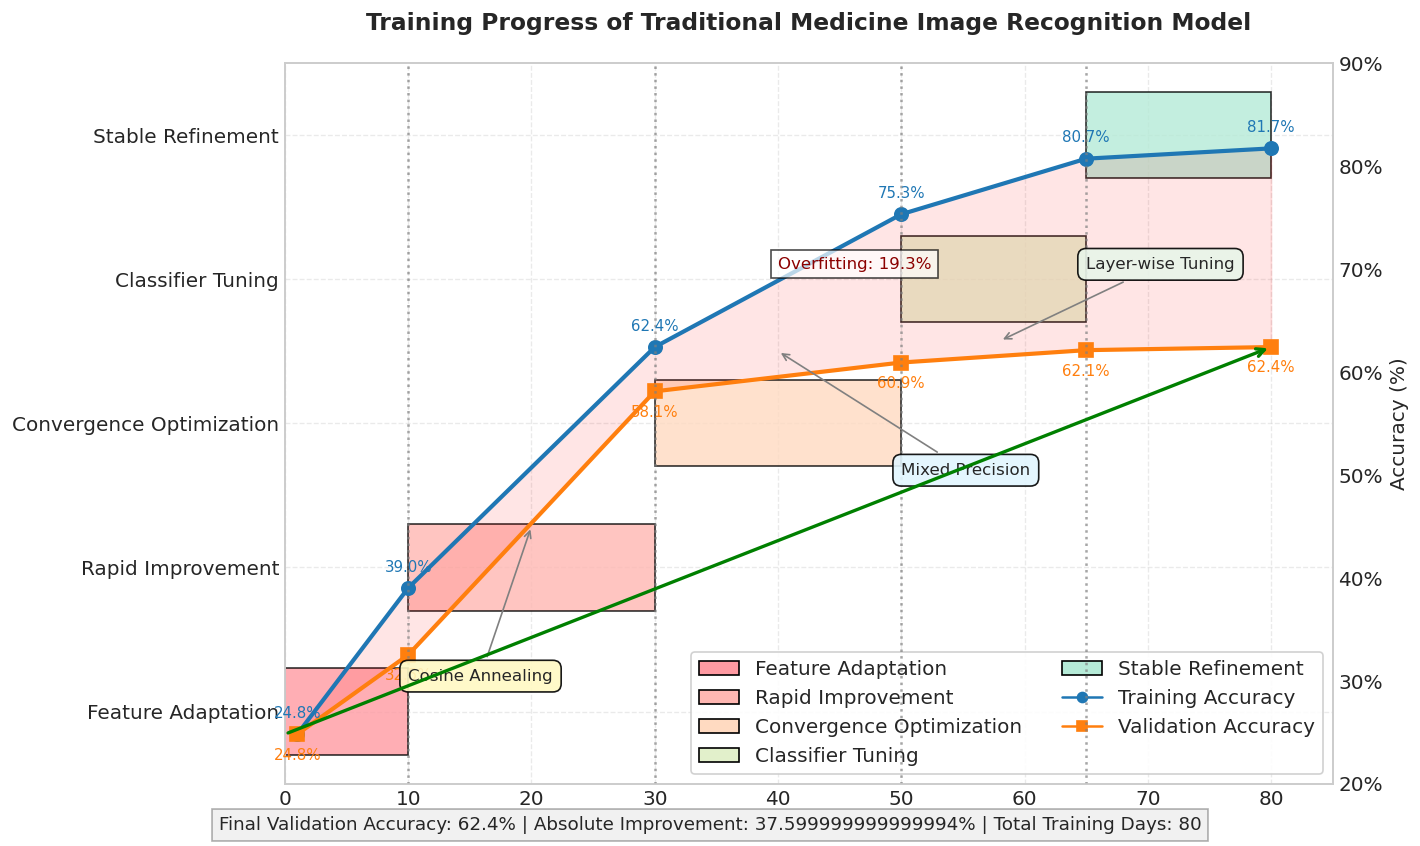

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

# 配置英文图表
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 12,
    'figure.figsize': (12, 7),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})

# 创建图表和双坐标轴
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# 训练阶段划分数据（英文）
stages = [
    "Feature Adaptation", "Rapid Improvement", "Convergence Optimization", 
    "Classifier Tuning", "Stable Refinement"
]
start_days = [0, 10, 30, 50, 65]
end_days = [10, 30, 50, 65, 80]
durations = [end - start for start, end in zip(start_days, end_days)]
colors = ['#FF9AA2', '#FFB7B2', '#FFDAC1', '#E2F0CB', '#B5EAD7']

# 绘制阶段条形图
for i, (stage, start, dur, color) in enumerate(zip(stages, start_days, durations, colors)):
    ax1.barh(
        y=stage, 
        width=dur, 
        left=start,
        color=color,
        edgecolor='black',
        height=0.6,
        alpha=0.8
    )

# 准确率数据点
epochs = np.array([1, 10, 30, 50, 65, 80])
acc_train = np.array([24.8, 39.0, 62.4, 75.3, 80.7, 81.7])
acc_val = np.array([24.8, 32.5, 58.1, 60.9, 62.1, 62.4])

# 绘制准确率曲线
ax2.plot(epochs, acc_train, 'o-', color='#1f77b4', 
         linewidth=2.5, markersize=8, label='Training Accuracy')
ax2.plot(epochs, acc_val, 's-', color='#ff7f0e', 
         linewidth=2.5, markersize=8, label='Validation Accuracy')

# 添加关键点标注
for ep, tr, val in zip(epochs, acc_train, acc_val):
    ax2.annotate(f'{tr}%', (ep, tr), 
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=9, color='#1f77b4')
    ax2.annotate(f'{val}%', (ep, val), 
                 xytext=(0, -15), textcoords='offset points',
                 ha='center', fontsize=9, color='#ff7f0e')

# 添加阶段分隔线
for day in [10, 30, 50, 65]:
    ax2.axvline(x=day, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

# 添加技术标注
ax2.annotate('Cosine Annealing', xy=(20, 45), xytext=(10, 30),
             arrowprops=dict(arrowstyle='->', color='gray', linewidth=1),
             fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='#FFF9C4', alpha=0.9))

ax2.annotate('Mixed Precision', xy=(40, 62), xytext=(50, 50),
             arrowprops=dict(arrowstyle='->', color='gray', linewidth=1),
             fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='#E1F5FE', alpha=0.9))

ax2.annotate('Layer-wise Tuning', xy=(58, 63), xytext=(65, 70),
             arrowprops=dict(arrowstyle='->', color='gray', linewidth=1),
             fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='#E8F5E9', alpha=0.9))

# 设置坐标轴属性

ax1.set_title('Training Progress of Traditional Medicine Image Recognition Model', 
              pad=20, fontsize=14, fontweight='bold')
ax1.set_xlim(0, 85)
ax1.set_ylim(-0.5, len(stages)-0.5)

ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(20, 90)
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.grid(False)

# 创建自定义图例
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label=stages[0]),
    Patch(facecolor=colors[1], edgecolor='black', label=stages[1]),
    Patch(facecolor=colors[2], edgecolor='black', label=stages[2]),
    Patch(facecolor=colors[3], edgecolor='black', label=stages[3]),
    Patch(facecolor=colors[4], edgecolor='black', label=stages[4]),
    Line2D([0], [0], color='#1f77b4', marker='o', label='Training Accuracy'),
    Line2D([0], [0], color='#ff7f0e', marker='s', label='Validation Accuracy')
]

ax1.legend(handles=legend_elements, loc='lower right', 
           frameon=True, framealpha=0.9, ncol=2)

# 添加关键指标注释
plt.figtext(0.5, 0, 
            f"Final Validation Accuracy: {acc_val[-1]}% | Absolute Improvement: {acc_val[-1]-acc_val[0]}% | Total Training Days: {end_days[-1]}", 
            fontsize=11, ha='center', bbox=dict(facecolor='lightgray', alpha=0.3))

# 添加过拟合率可视化
plt.fill_between(epochs, acc_train, acc_val, 
                 where=acc_train >= acc_val,
                 color='red', alpha=0.1)
plt.text(40, 70, f"Overfitting: {acc_train[-1]-acc_val[-1]:.1f}%", 
         fontsize=10, color='darkred', bbox=dict(facecolor='white', alpha=0.7))

# 添加性能提升箭头
ax2.annotate('', xy=(80, 62.4), xytext=(0, 24.8),
             arrowprops=dict(arrowstyle='->', color='green', linewidth=2, linestyle='-'))

# 显示图表
plt.tight_layout()

# 保存为图片
output_file = 'training_progress_en.png'
plt.savefig(output_file, dpi=200, bbox_inches='tight', format='png')
print(f"Chart saved as '{output_file}'")

plt.show()


In [2]:
#使用最佳模型继续训练30个epoch
NUM_EPOCHS = 30
# 重新加载模型
model = models.efficientnet_b3(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 881)
model = model.to(device)	
# 加载最佳模型权重
model.load_state_dict(torch.load('best_model.pth'))
# 冻结前面的层
for param in model.parameters():
	param.requires_grad = False
# 只训练最后的分类器
for param in model.classifier.parameters():
	param.requires_grad = True
# 重新定义优化器
optimizer = optim.AdamW(model.classifier.parameters(), lr=LR, weight_decay=1e-4)
# 重新定义学习率调度器
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
# 重新定义损失函数
criterion = nn.CrossEntropyLoss()
# 重新定义梯度缩放器
scaler = torch.cuda.amp.GradScaler()
# 继续训练
for epoch in range(NUM_EPOCHS):
	model.train()
	train_loss = 0.0
	correct = 0
	total = 0

	loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}]', mininterval=1)
	for images, targets in loop:
		# 跳过空batch
		if images is None or targets is None:
			continue

		images = images.to(device, non_blocking=True)
		targets = targets.to(device, non_blocking=True).long()  # 关键修改
		
		optimizer.zero_grad()
		
		with torch.cuda.amp.autocast():
			outputs = model(images)
			loss = criterion(outputs, targets)
		
		scaler.scale(loss).backward()
		scaler.step(optimizer)
		scaler.update()
		
		_, predicted = outputs.max(1)
		total += targets.size(0)
		correct += predicted.eq(targets).sum().item()
		
		loop.set_postfix(loss=loss.item(), acc=correct/total)
	# 验证
	model.eval()
	val_correct = 0
	val_total = 0
	with torch.no_grad():
		for images, targets in val_loader:
			images = images.to(device)
			targets = targets.to(device)
			outputs = model(images)
			_, predicted = outputs.max(1)
			val_total += targets.size(0)
			val_correct += predicted.eq(targets).sum().item()

	val_acc = val_correct / val_total
	print(f'Val Acc: {val_acc:.4f}')

	if val_acc > best_acc:
		best_acc = val_acc
		torch.save(model.state_dict(), 'best_model.pth')

	scheduler.step()

# 测试集预测
class TestDataset(Dataset):
	def __init__(self, root_dir, transform=None):
		self.root_dir = root_dir
		self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg'))]
		self.transform = transform

	def __len__(self):
		return len(self.image_files)

	def __getitem__(self, idx):
		img_path = os.path.join(self.root_dir, self.image_files[idx])
		image = Image.open(img_path).convert('RGB')
		if self.transform:
			image = self.transform(image)
		return image, self.image_files[idx]

# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 创建测试集
test_dataset = TestDataset('chinese-medicine-image/test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
						num_workers=NUM_WORKERS)

# 生成预测结果
results = []
with torch.no_grad():
	for images, filenames in test_loader:
		images = images.to(device)
		outputs = model(images)
		_, preds = torch.max(outputs, 1)
		for fn, p in zip(filenames, (preds+1).cpu().numpy()):  # 转换回1-based
			results.append(f"{fn}\t{int(p)}")

# 保存结果
with open('submission.txt', 'w') as f:
	f.write('\n'.join(results))


c:\Users\wyz20\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\wyz20\AppData\Local\Temp\ipykernel_23992\4129624423.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch [1/30]:   0%|          | 0/8351 [00:00<?, ?it/s]C:\Users\wyz20\AppData\Local\Temp\ipykernel_23992\4129624423.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch [1/30]: 100%|██████████| 8351/8351 [48:23<00:00,  2.88it/s, acc=0.778, loss=1.37]   


Val Acc: 0.6173


Epoch [2/30]: 100%|██████████| 8351/8351 [40:51<00:00,  3.41it/s, acc=0.787, loss=0.302] 


Val Acc: 0.6200


Epoch [3/30]: 100%|██████████| 8351/8351 [44:10<00:00,  3.15it/s, acc=0.788, loss=0.702] 


Val Acc: 0.6208


Epoch [4/30]: 100%|██████████| 8351/8351 [42:16<00:00,  3.29it/s, acc=0.792, loss=0.659] 


Val Acc: 0.6218


Epoch [5/30]: 100%|██████████| 8351/8351 [42:44<00:00,  3.26it/s, acc=0.793, loss=0.884] 


Val Acc: 0.6187


Epoch [6/30]: 100%|██████████| 8351/8351 [42:24<00:00,  3.28it/s, acc=0.795, loss=1.08]  


Val Acc: 0.6207


Epoch [7/30]: 100%|██████████| 8351/8351 [42:25<00:00,  3.28it/s, acc=0.797, loss=1.5]   


Val Acc: 0.6203


Epoch [8/30]: 100%|██████████| 8351/8351 [42:47<00:00,  3.25it/s, acc=0.798, loss=1.7]   


Val Acc: 0.6196


Epoch [9/30]: 100%|██████████| 8351/8351 [43:21<00:00,  3.21it/s, acc=0.799, loss=1.93]  


Val Acc: 0.6204


Epoch [10/30]: 100%|██████████| 8351/8351 [43:36<00:00,  3.19it/s, acc=0.799, loss=1.16]  


Val Acc: 0.6207


Epoch [11/30]: 100%|██████████| 8351/8351 [43:18<00:00,  3.21it/s, acc=0.801, loss=0.553] 


Val Acc: 0.6204


Epoch [12/30]: 100%|██████████| 8351/8351 [44:12<00:00,  3.15it/s, acc=0.803, loss=1.21]  


Val Acc: 0.6214


Epoch [13/30]: 100%|██████████| 8351/8351 [43:17<00:00,  3.21it/s, acc=0.804, loss=0.632] 


Val Acc: 0.6217


Epoch [14/30]: 100%|██████████| 8351/8351 [43:47<00:00,  3.18it/s, acc=0.804, loss=0.229] 


Val Acc: 0.6230


Epoch [15/30]: 100%|██████████| 8351/8351 [43:02<00:00,  3.23it/s, acc=0.807, loss=0.37]  


Val Acc: 0.6218


Epoch [16/30]: 100%|██████████| 8351/8351 [42:31<00:00,  3.27it/s, acc=0.806, loss=1.58]  


Val Acc: 0.6216


Epoch [17/30]: 100%|██████████| 8351/8351 [42:30<00:00,  3.27it/s, acc=0.808, loss=0.605] 


Val Acc: 0.6226


Epoch [18/30]: 100%|██████████| 8351/8351 [42:53<00:00,  3.24it/s, acc=0.81, loss=1.02]   


Val Acc: 0.6215


Epoch [19/30]: 100%|██████████| 8351/8351 [42:59<00:00,  3.24it/s, acc=0.81, loss=0.924]  


Val Acc: 0.6218


Epoch [20/30]: 100%|██████████| 8351/8351 [42:54<00:00,  3.24it/s, acc=0.811, loss=0.854] 


Val Acc: 0.6216


Epoch [21/30]: 100%|██████████| 8351/8351 [42:40<00:00,  3.26it/s, acc=0.811, loss=0.952] 


Val Acc: 0.6244


Epoch [22/30]: 100%|██████████| 8351/8351 [43:17<00:00,  3.21it/s, acc=0.813, loss=0.954] 


Val Acc: 0.6227


Epoch [23/30]: 100%|██████████| 8351/8351 [47:02<00:00,  2.96it/s, acc=0.813, loss=1.13]    


Val Acc: 0.6241


Epoch [24/30]: 100%|██████████| 8351/8351 [46:17<00:00,  3.01it/s, acc=0.814, loss=0.139] 


Val Acc: 0.6236


Epoch [25/30]: 100%|██████████| 8351/8351 [45:40<00:00,  3.05it/s, acc=0.815, loss=0.146] 


Val Acc: 0.6245


Epoch [26/30]: 100%|██████████| 8351/8351 [43:27<00:00,  3.20it/s, acc=0.814, loss=0.853] 


Val Acc: 0.6239


Epoch [27/30]: 100%|██████████| 8351/8351 [40:32<00:00,  3.43it/s, acc=0.815, loss=1.58]  


Val Acc: 0.6233


Epoch [28/30]: 100%|██████████| 8351/8351 [42:14<00:00,  3.29it/s, acc=0.815, loss=1.26]  


Val Acc: 0.6237


Epoch [29/30]: 100%|██████████| 8351/8351 [42:35<00:00,  3.27it/s, acc=0.815, loss=1.45]   


Val Acc: 0.6230


Epoch [30/30]: 100%|██████████| 8351/8351 [43:03<00:00,  3.23it/s, acc=0.817, loss=0.877] 


Val Acc: 0.6238
